In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"   # avoid Windows MKL/KMeans warning
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
FEATURE_DIR = r"data\features"   # folder produced by the improved feature extraction notebook
FEATURE_CSV = os.path.join(FEATURE_DIR, "features_master.csv")
OUT_DIR = r"data\clusters"
os.makedirs(OUT_DIR, exist_ok=True)

N_COMPONENTS_PCA = 3          # for visualization / optional dimensionality reduction
GMM_COMPONENTS = 4           # you chose 4 clusters
RANDOM_STATE = 42

# Which columns to use for composite score & clustering (tweakable).
# We'll automatically select sensible subsets: power-like, freq, timing, symmetry, coact, consistency candidates.
AUTO_FEATURE_KEYWORDS = [
    "__rms", "__peak", "__iEMG", "__mnf", "__mdf", "__time_to_peak", "__dur_halfmax",
    "__mrms_mean", "__mrms_peak", "coact", "LR_mean_ratio", "__std", "__wl"
]

TINY_CLUSTER_THRESHOLD = 3  # clusters with fewer samples than this will be marked TENTATIVE

# Name of output benchmark JSON
BENCHMARK_JSON = os.path.join(OUT_DIR, "benchmark_gmm_4clusters.json")
print("FEATURE_CSV:", FEATURE_CSV)
print("OUT_DIR:", OUT_DIR)

FEATURE_CSV: data\features\features_master.csv
OUT_DIR: data\clusters


In [3]:
# Cell 2 - load feature table and quick checks
if not os.path.exists(FEATURE_CSV):
    raise FileNotFoundError(f"Feature CSV not found: {FEATURE_CSV}")

df = pd.read_csv(FEATURE_CSV)
print("Loaded features:", df.shape)
print("Columns (sample):", df.columns.tolist()[:50])

# drop rows with too few samples if 'n_samples' present and you want to filter
if 'n_samples' in df.columns:
    # optional: filter very short trials (uncomment if desired)
    # df = df[df['n_samples'] >= 10].reset_index(drop=True)
    pass

# auto-select candidate features
candidate_cols = []
for col in df.columns:
    for kw in AUTO_FEATURE_KEYWORDS:
        if kw.lower() in col.lower():
            candidate_cols.append(col)
            break
candidate_cols = sorted(list(set(candidate_cols)))
if len(candidate_cols) == 0:
    # fallback to numeric columns except metadata
    exclude = {'file','player','n_samples','fs_used','gmm_label','gmm_confidence','performance_level','performance_level_confidence','_proxy_score'}
    candidate_cols = [c for c in df.columns if c not in exclude and np.issubdtype(df[c].dtype, np.number)]
print("Selected candidate features:", len(candidate_cols))
print(candidate_cols[:40])


Loaded features: (210, 194)
Columns (sample): ['file', 'player', 'n_samples', 'fs_used', 'Rectus Femoris right__mean', 'Rectus Femoris right__std', 'Rectus Femoris right__rms', 'Rectus Femoris right__rms_rel', 'Rectus Femoris right__mav', 'Rectus Femoris right__mav_rel', 'Rectus Femoris right__wl', 'Rectus Femoris right__peak', 'Rectus Femoris right__peak_rel', 'Rectus Femoris right__iEMG', 'Rectus Femoris right__iEMG_rel', 'Rectus Femoris right__mnf', 'Rectus Femoris right__mdf', 'Rectus Femoris right__bp_20_60', 'Rectus Femoris right__bp_60_100', 'Rectus Femoris right__bp_100_200', 'Rectus Femoris right__time_to_peak_s', 'Rectus Femoris right__dur_halfmax_s', 'Rectus Femoris right__mrms_mean', 'Rectus Femoris right__mrms_mean_rel', 'Rectus Femoris right__mrms_peak', 'Rectus Femoris right__mrms_peak_rel', 'Rectus Femoris left__mean', 'Rectus Femoris left__std', 'Rectus Femoris left__rms', 'Rectus Femoris left__rms_rel', 'Rectus Femoris left__mav', 'Rectus Femoris left__mav_rel', 'Rect

In [4]:
# Cell 3 - prepare feature matrix: handle NaNs and standardize
X_raw = df[candidate_cols].copy().astype(float)
# fill NaNs with column median for robustness
X_filled = X_raw.fillna(X_raw.median())
scaler = StandardScaler().fit(X_filled)
X_scaled = scaler.transform(X_filled)

# PCA for visualization (optional)
pca = PCA(n_components=min(N_COMPONENTS_PCA, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Save scaler + pca
pd.to_pickle(scaler, os.path.join(OUT_DIR, "scaler.pkl"))
pd.to_pickle(pca, os.path.join(OUT_DIR, "pca.pkl"))

print("X shape:", X_scaled.shape)
print("Explained var ratio (PCA):", getattr(pca, "explained_variance_ratio_", None))


X shape: (210, 136)
Explained var ratio (PCA): [0.28638017 0.21503462 0.10229887]


In [5]:
# Cell 4 - fit GMM (with basic sample-size guard)
n_samples = X_scaled.shape[0]
if n_samples < GMM_COMPONENTS:
    raise ValueError(f"Not enough samples ({n_samples}) for GMM with {GMM_COMPONENTS} components. "
                     "Reduce GMM_COMPONENTS or add more data.")

gmm = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type='full', random_state=RANDOM_STATE, n_init=5)
gmm.fit(X_scaled)
probs = gmm.predict_proba(X_scaled)
labels = gmm.predict(X_scaled)
df['gmm_label'] = labels
df['gmm_confidence'] = probs.max(axis=1)
print("GMM fitted. Cluster counts:", df['gmm_label'].value_counts().sort_index().to_dict())


GMM fitted. Cluster counts: {0: 42, 1: 60, 2: 60, 3: 48}


In [6]:
# Cell 5 - compute proxy ordering and map to performance labels
def cluster_ordering_score_matrix(df_local):
    # build proxy from candidate_cols: power-like + freq - timing
    core_power = [c for c in candidate_cols if "__rms" in c or "__iEMG" in c or "__mrms_mean" in c]
    core_freq  = [c for c in candidate_cols if "__mnf" in c or "__mdf" in c]
    core_timing = [c for c in candidate_cols if "__time_to_peak" in c or "__dur_halfmax" in c]
    score = pd.Series(0.0, index=df_local.index)
    if len(core_power) > 0:
        score = score.add(zscore(df_local[core_power].mean(axis=1).fillna(0.0)), fill_value=0)
    if len(core_freq) > 0:
        score = score.add(0.5 * zscore(df_local[core_freq].mean(axis=1).fillna(0.0)), fill_value=0)
    if len(core_timing) > 0:
        score = score.add(-0.7 * zscore(df_local[core_timing].mean(axis=1).fillna(0.0)), fill_value=0)
    return score

df['_proxy_score'] = cluster_ordering_score_matrix(df)

cluster_means = df.groupby('gmm_label')['_proxy_score'].mean().sort_values(ascending=True)
cluster_order = list(cluster_means.index)
print("Cluster ordering (low->high) by proxy score:", cluster_order)

performance_labels = ["Poor", "Below-Average", "Average", "Excellent"]
label_map = {}
for i, cluster_idx in enumerate(cluster_order):
    label_map[cluster_idx] = performance_labels[min(i, len(performance_labels)-1)]

df['performance_level'] = df['gmm_label'].map(label_map)
df['performance_level_confidence'] = df['gmm_confidence']

print("Assigned performance_level counts:", df['performance_level'].value_counts().to_dict())


Cluster ordering (low->high) by proxy score: [1, 2, 0, 3]
Assigned performance_level counts: {'Poor': 60, 'Below-Average': 60, 'Excellent': 48, 'Average': 42}


In [7]:
cluster_sizes = df['gmm_label'].value_counts()
tiny_clusters = cluster_sizes[cluster_sizes < TINY_CLUSTER_THRESHOLD].index.tolist()
print("Tiny clusters (n < {}): {}".format(TINY_CLUSTER_THRESHOLD, tiny_clusters))

df['performance_level_adjusted'] = df['performance_level'].astype(str)
for cl in tiny_clusters:
    mask = df['gmm_label'] == cl
    df.loc[mask, 'performance_level_adjusted'] = df.loc[mask, 'performance_level'].astype(str) + "_TENTATIVE"

print("Adjusted performance_level counts:")
print(df['performance_level_adjusted'].value_counts().to_dict())


Tiny clusters (n < 3): []
Adjusted performance_level counts:
{'Poor': 60, 'Below-Average': 60, 'Excellent': 48, 'Average': 42}


In [8]:
orig_out = os.path.join(OUT_DIR, "features_master_labeled_gmm4.csv")
df.to_csv(orig_out, index=False)
print("Saved original labeled CSV:", orig_out)

adj_out = os.path.join(OUT_DIR, "features_master_labeled_with_tentative.csv")
df.to_csv(adj_out, index=False)
print("Saved adjusted labeled CSV:", adj_out)

# save GMM model
pd.to_pickle(gmm, os.path.join(OUT_DIR, "gmm_model.pkl"))
print("Saved GMM model:", os.path.join(OUT_DIR, "gmm_model.pkl"))


Saved original labeled CSV: data\clusters\features_master_labeled_gmm4.csv
Saved adjusted labeled CSV: data\clusters\features_master_labeled_with_tentative.csv
Saved GMM model: data\clusters\gmm_model.pkl


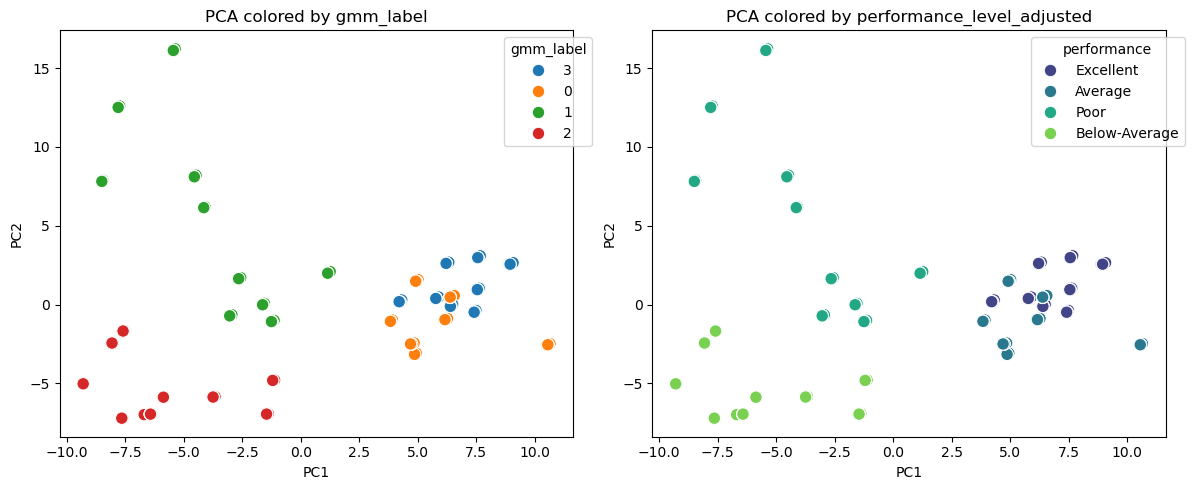


Cluster sizes: {1: 60, 2: 60, 3: 48, 0: 42}
GMM confidence summary:
 count    210.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: gmm_confidence, dtype: float64

Per-level counts (adjusted):
 performance_level_adjusted
Poor             60
Below-Average    60
Excellent        48
Average          42
Name: count, dtype: int64


In [9]:
plt.figure(figsize=(12,5))
if X_pca.shape[1] >= 2:
    plt.subplot(1,2,1)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['gmm_label'].astype(str), palette='tab10', s=80)
    plt.title("PCA colored by gmm_label")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title="gmm_label", bbox_to_anchor=(1.05,1))

    plt.subplot(1,2,2)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['performance_level_adjusted'], palette='viridis', s=80)
    plt.title("PCA colored by performance_level_adjusted")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title="performance", bbox_to_anchor=(1.05,1))
else:
    plt.scatter(X_pca[:,0], df['_proxy_score'], c=df['gmm_label'], cmap='tab10')
    plt.title("PC1 vs proxy_score colored by gmm_label")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_clusters.png"), bbox_inches='tight', dpi=200)
plt.show()

# print cluster summaries for quick review
print("\nCluster sizes:", df['gmm_label'].value_counts().to_dict())
if 'gmm_confidence' in df.columns:
    print("GMM confidence summary:\n", df['gmm_confidence'].describe())
print("\nPer-level counts (adjusted):\n", df['performance_level_adjusted'].value_counts())


In [10]:
examples = {}
for cl, grp in df.groupby('gmm_label'):
    examples[int(cl)] = {
        "n": int(len(grp)),
        "top_by_conf": grp.sort_values('gmm_confidence', ascending=False).head(3)[['file','player','gmm_confidence','_proxy_score']].to_dict(orient='records'),
        "bottom_by_conf": grp.sort_values('gmm_confidence', ascending=True).head(3)[['file','player','gmm_confidence','_proxy_score']].to_dict(orient='records'),
        "top_by_proxy": grp.sort_values('_proxy_score', ascending=False).head(3)[['file','player','_proxy_score','gmm_confidence']].to_dict(orient='records'),
        "bottom_by_proxy": grp.sort_values('_proxy_score', ascending=True).head(3)[['file','player','_proxy_score','gmm_confidence']].to_dict(orient='records')
    }

with open(os.path.join(OUT_DIR, "cluster_examples.json"), "w") as f:
    json.dump(examples, f, indent=2)
print("Saved cluster_examples.json")


Saved cluster_examples.json
